# Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import spacy
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns
####################
import gensim
import string
from gensim.models import Word2Vec
import PyPDF2
#######################
from gensim.models import KeyedVectors
from sklearn.metrics import confusion_matrix
#########
import random
import re
from sklearn.svm import LinearSVC

# análisis de texto



In [2]:
# --- 1. Preparación de Datos ---
# Se crea el DataFrame a partir de la muestra de datos proporcionada.

df = pd.read_excel('/home/jmanriquez/triage/solo_glosa_y_triage_dataset_extendido.xlsx')
df = df[df['niv_cod'] != 'SC']

df = df[["tri_motivo_cons", "niv_cod"]]
df = df.dropna()

# print("--- Dataset Original ---")
# print(df)
# print("\n" + "="*50 + "\n")


In [3]:
# --- 2. Limpieza de Texto (Fase 1) ---
def clean_text(text):
    """Función para limpiar el texto: minúsculas, sin puntuación, sin números."""
    text = text.lower()  # a minúsculas
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # elimina puntuación
    text = re.sub(r'\d+', '', text)  # elimina números
    text = re.sub(r'\s+', ' ', text).strip()  # elimina espacios extra
    return text

df['texto_limpio'] = df['tri_motivo_cons'].apply(clean_text)

# print("--- Texto después de Limpieza Básica ---")
# print(df[['tri_motivo_cons', 'texto_limpio']].head())
# print("\n" + "="*50 + "\n")

In [4]:
# --- 3. Preprocesamiento Léxico con spaCy (Fase 2) ---
# Cargar modelo de español de spaCy.
nlp = spacy.load('es_dep_news_trf')

def preprocess_spacy(text):
    """
    Función para procesar texto usando spaCy:
    - Tokenización
    - Eliminación de stopwords
    - Lematización
    """
    doc = nlp(text)
    # Se filtran los tokens que no son stopword ni puntuación, y se obtiene su lema.
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(lemmas)

df['texto_procesado'] = df['texto_limpio'].apply(preprocess_spacy)

# print("--- Texto después de Procesamiento con spaCy (Lematización) ---")
# print(df[['texto_limpio', 'texto_procesado']].head())
# print("\n" + "="*50 + "\n")

/home/jmanriquez/proyectos/steiner/venv311/lib/python3.11/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


In [5]:
#df.to_csv('/home/jmanriquez/triage/df_preprocesado_es_dep_news_trf.csv', index=False, encoding='utf-8')

## Subsample

In [6]:
# Find the minimum number of samples among all classes
min_samples = df['niv_cod'].value_counts().min()

# Create an empty list to store the balanced dataframes
balanced_dfs = []

# Iterate over each class and sample the minimum number of samples
for class_name in df['niv_cod'].unique():
    class_df = df[df['niv_cod'] == class_name]
    balanced_class_df = class_df.sample(min_samples, random_state=42) # Using random_state for reproducibility
    balanced_dfs.append(balanced_class_df)

# Concatenate the balanced dataframes
df_balanced = pd.concat(balanced_dfs)

# Shuffle the balanced dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# display(df_balanced['niv_cod'].value_counts())

In [7]:
# --- 4. Preparación para el Modelo ---
# Separar características (X) y variable objetivo (y)
X = df_balanced['texto_procesado']
y = df_balanced['niv_cod']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorización con TF-IDF y N-gramas (1, 2)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Dimensiones de la matriz TF-IDF de entrenamiento: {X_train_tfidf.shape}")
print(f"Dimensiones de la matriz TF-IDF de prueba: {X_test_tfidf.shape}")
print("\n" + "="*50 + "\n")

Dimensiones de la matriz TF-IDF de entrenamiento: (3448, 16114)
Dimensiones de la matriz TF-IDF de prueba: (862, 16114)




--- Evaluando Modelo: Support Vector Machine (LinearSVC) ---
Reporte de Clasificación:
              precision    recall  f1-score   support

          C1       0.87      0.88      0.87       173
          C2       0.73      0.66      0.70       172
          C3       0.60      0.60      0.60       172
          C4       0.43      0.47      0.45       173
          C5       0.58      0.56      0.57       172

    accuracy                           0.63       862
   macro avg       0.64      0.63      0.64       862
weighted avg       0.64      0.63      0.64       862

Precisión (Accuracy): 0.63



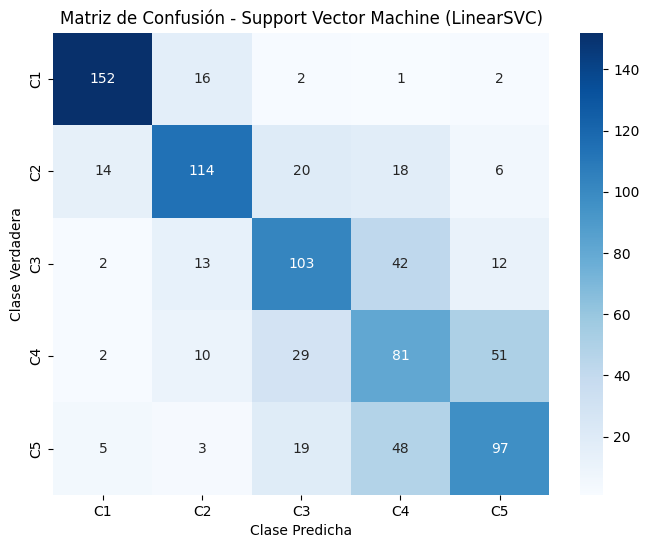

--- Evaluando Modelo: Multinomial Naive Bayes ---
Reporte de Clasificación:
              precision    recall  f1-score   support

          C1       0.85      0.88      0.87       173
          C2       0.77      0.65      0.70       172
          C3       0.66      0.59      0.62       172
          C4       0.44      0.60      0.51       173
          C5       0.60      0.52      0.56       172

    accuracy                           0.65       862
   macro avg       0.66      0.65      0.65       862
weighted avg       0.66      0.65      0.65       862

Precisión (Accuracy): 0.65



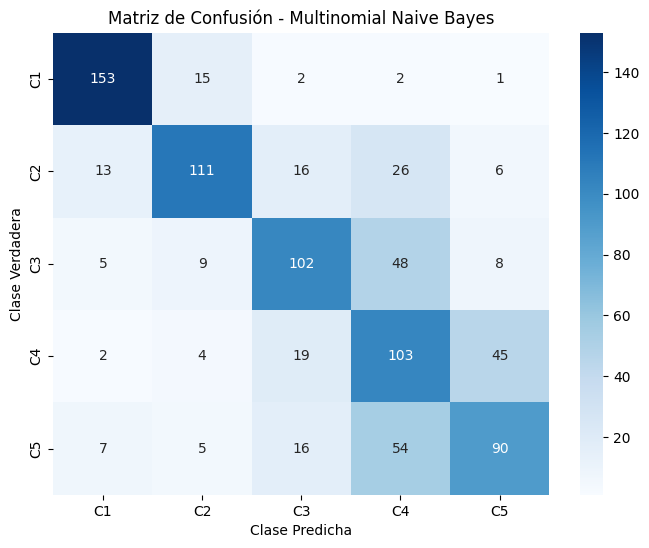

In [8]:

# --- 5. Entrenamiento y Evaluación de Modelos ---
# Función para entrenar, predecir y evaluar
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print(f"--- Evaluando Modelo: {model_name} ---")

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Mostrar reporte de clasificación
    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Calcular y mostrar la precisión global
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión (Accuracy): {accuracy:.2f}\n")

    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.show()


# Inicializar los modelos
svc = LinearSVC(random_state=42)
mnb = MultinomialNB()

# Evaluar ambos modelos
train_evaluate_model(svc, X_train_tfidf, y_train, X_test_tfidf, y_test, "Support Vector Machine (LinearSVC)")
train_evaluate_model(mnb, X_train_tfidf, y_train, X_test_tfidf, y_test, "Multinomial Naive Bayes")

# Deeplearning

In [9]:
df = pd.read_csv('/home/jmanriquez/triage/df_preprocesado_es_dep_news_trf.csv', encoding='utf-8')
df = df[df['niv_cod'] != 'SC']
df = df.dropna()

In [10]:
# Find the minimum number of samples among all classes
min_samples = df['niv_cod'].value_counts().min()

# Create an empty list to store the balanced dataframes
balanced_dfs = []

# Iterate over each class and sample the minimum number of samples
for class_name in df['niv_cod'].unique():
    class_df = df[df['niv_cod'] == class_name]
    balanced_class_df = class_df.sample(min_samples, random_state=42) # Using random_state for reproducibility
    balanced_dfs.append(balanced_class_df)

# Concatenate the balanced dataframes
df_balanced = pd.concat(balanced_dfs)

# Shuffle the balanced dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

display(df_balanced['niv_cod'].value_counts())

niv_cod
C2    862
C5    862
C1    862
C4    862
C3    862
Name: count, dtype: int64

In [11]:
X = df_balanced['texto_procesado']
y = df_balanced['niv_cod']


In [12]:
import pandas as pd
import numpy as np
import re
import string
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint

2025-09-04 14:41:08.601063: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-04 14:41:08.642468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-04 14:41:09.818326: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [13]:


# Tokenizar el texto
VOCAB_SIZE = 2000  # Tamaño máximo del vocabulario
tokenizer = Tokenizer(num_words=VOCAB_SIZE )
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Padding para asegurar longitud uniforme
MAX_LEN = 10  # Longitud máxima de una secuencia
X_padded = pad_sequences(X_sequences, maxlen=MAX_LEN, padding='post')

# Codificar las etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = len(label_encoder.classes_)

In [14]:
# Calculate the number of unique words
unique_words = len(tokenizer.word_index)
print(f"Número de palabras distintas en el dataset: {unique_words}")

# Calculate the average length of the sequences
average_sequence_length = np.mean([len(seq) for seq in X_sequences])
print(f"Largo promedio de las secuencias: {average_sequence_length:.2f}")

Número de palabras distintas en el dataset: 3867
Largo promedio de las secuencias: 7.77


In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0000001, mode="min")
early_st = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode="min")

Dimensiones de los datos de entrenamiento (X_train): (3448, 10)
Dimensiones de las etiquetas de entrenamiento (y_train): (3448, 5)




I0000 00:00:1757011270.608528 1105756 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14129 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:c3:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo LSTM...
Epoch 1/30


2025-09-04 14:41:12.373040: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


690/690 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4877 - loss: 1.1451 - val_accuracy: 0.5667 - val_loss: 0.9694 - learning_rate: 0.0010
Epoch 2/30
690/690 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6530 - loss: 0.8300 - val_accuracy: 0.6043 - val_loss: 0.9274 - learning_rate: 0.0010
Epoch 3/30
690/690 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7371 - loss: 0.6740 - val_accuracy: 0.6014 - val_loss: 1.0741 - learning_rate: 0.0010
Epoch 4/30
690/690 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7908 - loss: 0.5576 - val_accuracy: 0.6014 - val_loss: 1.0417 - learning_rate: 0.0010
Epoch 5/30
690/690 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8270 - loss: 0.4760 - val_accuracy: 0.6000 - val_loss: 1.1114 - learning_rate: 0.0010
Epoch 6/30
690/690 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8945 - loss: 0.3215 - val_accuracy: 0.6058 - val_loss: 1.1851 - learning_rate: 1.0000e-04
Epoch 7/30
690/690 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9003 - loss: 0.3004 -

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo CNN...
Epoch 1/30


2025-09-04 14:43:05.636298: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f01eca54e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-04 14:43:05.636348: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-09-04 14:43:05.702933: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 28/138 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2572 - loss: 1.5768

I0000 00:00:1757011387.301687 1106272 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.4761 - loss: 1.2850 - val_accuracy: 0.5478 - val_loss: 1.0272 - learning_rate: 0.0010
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6838 - loss: 0.8347 - val_accuracy: 0.5913 - val_loss: 0.9374 - learning_rate: 0.0010
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7977 - loss: 0.5696 - val_accuracy: 0.5942 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8999 - loss: 0.3663 - val_accuracy: 0.6087 - val_loss: 1.0215 - learning_rate: 1.0000e-04
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9065 - loss: 0.3453 - val_accuracy: 0.6000 - val_loss: 1.0354 - learning_rate: 1.0000e-04
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9108 - loss: 0.3272 - val_accuracy: 0.6014 - val_loss: 1.0501 - learning_rate: 1.0000e-04
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9181 - loss: 0.3098 

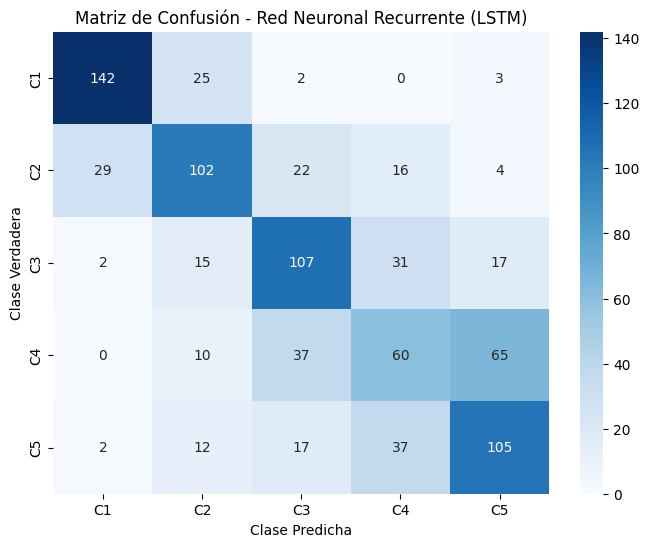

--- Evaluando Modelo: Red Neuronal Convolucional (CNN) ---
Precisión (Accuracy) en Test: 0.56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

          C1       0.84      0.84      0.84       172
          C2       0.67      0.64      0.65       173
          C3       0.42      0.67      0.52       172
          C4       0.43      0.44      0.43       172
          C5       0.54      0.23      0.32       173

    accuracy                           0.56       862
   macro avg       0.58      0.56      0.55       862
weighted avg       0.58      0.56      0.55       862



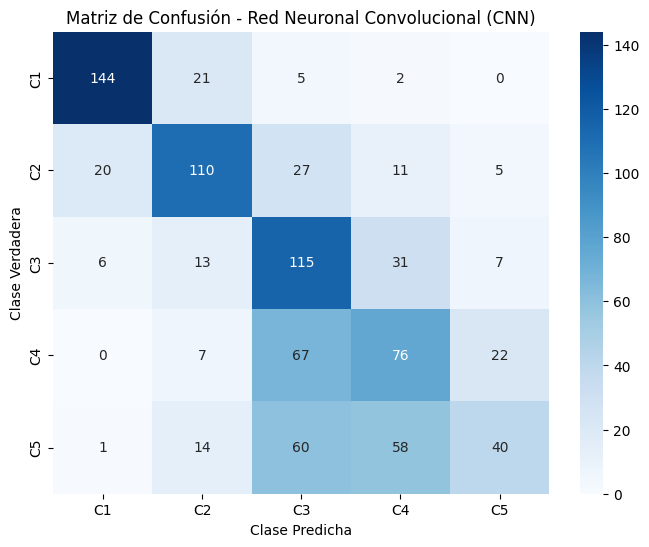

In [16]:

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

print(f"Dimensiones de los datos de entrenamiento (X_train): {X_train.shape}")
print(f"Dimensiones de las etiquetas de entrenamiento (y_train): {y_train.shape}")
print("\n" + "="*50 + "\n")

# --- 3. Modelo 1: Embeddings + LSTM ---
EMBEDDING_DIM = 128
model_lstm = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    LSTM(64),  # 100 unidades en la capa LSTM
    Dense(num_classes, activation='softmax')
])
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

print("\nEntrenando modelo LSTM...")
history_lstm = model_lstm.fit(X_train, y_train, epochs=30, batch_size=4, validation_split=0.2, verbose=1, callbacks=[reduce_lr,early_st])
print("Entrenamiento completado.")

# --- 4. Modelo 2: Embeddings + CNN ---
model_cnn = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(num_classes, activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

print("\nEntrenando modelo CNN...")
history_cnn = model_cnn.fit(X_train, y_train, epochs=30, batch_size=20, validation_split=0.2, verbose=1, callbacks=[reduce_lr,early_st])
print("Entrenamiento completado.")
print("\n" + "="*50 + "\n")


# --- 5. Evaluación de Modelos ---
def evaluate_nn_model(model, X_test, y_test, model_name):
    print(f"--- Evaluando Modelo: {model_name} ---")

    # Evaluar en el conjunto de prueba
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Precisión (Accuracy) en Test: {accuracy:.2f}")

    # Predecir clases
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Reporte de Clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))

    # Matriz de Confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.show()

# Evaluar ambos modelos
evaluate_nn_model(model_lstm, X_test, y_test, "Red Neuronal Recurrente (LSTM)")
evaluate_nn_model(model_cnn, X_test, y_test, "Red Neuronal Convolucional (CNN)")

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# --- 1. Preparación de Datos (Ejemplo) ---
# Usamos los mismos datos que en el ejemplo anterior
VOCAB_SIZE = 1500
MAX_LEN = 15
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=MAX_LEN, padding='post')

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = len(label_encoder.classes_)

# --- 3. Construcción del Modelo Híbrido CNN + LSTM ---
EMBEDDING_DIM = 64
model_hybrid = Sequential([
    # 1. Capa de Embedding (entrenada desde cero en este ejemplo)
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),

    # 2. Capa CNN para extraer características (frases clave)
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # 3. Capa LSTM para entender el contexto de las características extraídas
    LSTM(64),

    # 4. Capa de Regularización y Salida
    Dense(num_classes, activation='softmax')
])

model_hybrid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_hybrid.summary()

# --- 4. Entrenamiento y Evaluación ---
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)
print("\nEntrenando modelo Híbrido CNN+LSTM...")
model_hybrid.fit(X_train, y_train, epochs=20, batch_size=10, validation_split=0.2, verbose=0, callbacks=[reduce_lr,early_st])
print("Entrenamiento completado.")

loss, accuracy = model_hybrid.evaluate(X_test, y_test, verbose=0)
print(f"\nPrecisión (Accuracy) en Test: {accuracy:.2f}")

y_pred_probs = model_hybrid.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo Híbrido CNN+LSTM...
Entrenamiento completado.

Precisión (Accuracy) en Test: 0.51
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

          C1       0.87      0.83      0.85       172
          C2       0.60      0.64      0.62       173
          C3       0.39      0.41      0.40       172
          C4       0.35      0.68      0.46       172
          C5       0.00      0.00      0.00       173

    accuracy                           0.51       862
   macro avg       0.44      0.51      0.47       862
weighted avg       0.44      0.51      0.47       862



In [18]:
import pandas as pd
import numpy as np
import re
import string
import spacy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, concatenate
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Define MAX_LEN here
MAX_LEN = 15 # You can adjust this value based on your data

embedding_dim = 50

# Entrada
input_layer = Input(shape=(MAX_LEN,))

# Capa de embedding compartida
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_dim, input_length=MAX_LEN)(input_layer)

# Rama LSTM
lstm_branch = LSTM(128, return_sequences=True)(embedding_layer)
lstm_branch = GlobalMaxPooling1D()(lstm_branch)

# Rama CNN
cnn_branch = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding_layer)
cnn_branch = GlobalMaxPooling1D()(cnn_branch)

# Concatenación
merged = concatenate([lstm_branch, cnn_branch])
merged = Dropout(0.3)(merged)
merged = Dense(32, activation='relu')(merged)
output_layer = Dense(num_classes, activation='softmax')(merged)

# Definir modelo
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=20, batch_size=10, validation_split=0.2, verbose=0, callbacks=[reduce_lr,early_st])


loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPrecisión (Accuracy) en Test: {accuracy:.2f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))

/home/jmanriquez/proyectos/steiner/venv311/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 15, 50)    │     75,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 15, 128)   │     91,648 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 13, 128)   │     19,328 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ lstm_2[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      8,224 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 5)         │        165 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 194,365 (759.24 KB)

 Trainable params: 194,365 (759.24 KB)

 Non-trainable params: 0 (0.00 B)


Precisión (Accuracy) en Test: 0.57
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

          C1       0.88      0.82      0.85       172
          C2       0.64      0.68      0.66       173
          C3       0.73      0.46      0.56       172
          C4       0.37      0.87      0.52       172
          C5       0.71      0.03      0.06       173

    accuracy                           0.57       862
   macro avg       0.67      0.57      0.53       862
weighted avg       0.67      0.57      0.53       862



In [19]:
import pandas as pd
import numpy as np
import re
import string
import spacy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


# Tokenización y Padding
VOCAB_SIZE = 2000
MAX_LEN = 10
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=MAX_LEN, padding='post')

# Codificación de etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = len(label_encoder.classes_)

# --- 2. Carga de Embeddings Pre-entrenados ---
print("Cargando vectores de palabras pre-entrenados (GloVe)...")
embeddings_index = {}
# Asegúrate de que el archivo 'glove-sbwc.i25.vec' esté en la misma carpeta
try:
    with open('/home/jmanriquez/triage/glove-sbwc.i25.vec', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    print("\nERROR: Archivo 'glove-sbwc.i25.vec' no encontrado.")
    print("Por favor, descarga los vectores y colócalos en la carpeta del script.")
    exit()

print(f"Se encontraron {len(embeddings_index)} vectores de palabras.")

# --- 3. Creación de la Matriz de Embeddings ---
EMBEDDING_DIM = 300 # Debe coincidir con la dimensión de los vectores GloVe cargados
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Palabras encontradas en el índice de embeddings serán agregadas a la matriz
        embedding_matrix[i] = embedding_vector

print(f"Dimensión de la matriz de embeddings: {embedding_matrix.shape}")

# --- 4. Construcción del Modelo ---
model_glove = Sequential([
    # La capa Embedding se inicializa con la matriz pre-entrenada
    Embedding(input_dim=len(word_index) + 1,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix], # Carga de pesos
              input_length=MAX_LEN,
              trainable=False), # Se "congelan" los pesos para no perder el conocimiento pre-entrenado
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    #LSTM(128),
    #Dropout(0.4), # Dropout para regularización
    Dense(num_classes, activation='softmax')
])

model_glove.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_glove.summary()

# --- 5. Entrenamiento y Evaluación ---
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)
print("\nEntrenando modelo con Embeddings Pre-entrenados...")
model_glove.fit(X_train, y_train, epochs=20, batch_size=10, validation_split=0.2, verbose=1, callbacks=[reduce_lr, early_st])
print("Entrenamiento completado.")

loss, accuracy = model_glove.evaluate(X_test, y_test, verbose=0)
print(f"\nPrecisión (Accuracy) en Test: {accuracy:.2f}")

y_pred_probs = model_glove.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))

Cargando vectores de palabras pre-entrenados (GloVe)...
Se encontraron 855381 vectores de palabras.
Dimensión de la matriz de embeddings: (3868, 300)


/home/jmanriquez/proyectos/steiner/venv311/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     1,160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160,400 (4.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,160,400 (4.43 MB)


Entrenando modelo con Embeddings Pre-entrenados...
Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5392 - loss: 1.1128 - val_accuracy: 0.5899 - val_loss: 0.9768 - learning_rate: 0.0010
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7647 - loss: 0.6339 - val_accuracy: 0.5855 - val_loss: 1.0174 - learning_rate: 0.0010
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8662 - loss: 0.4033 - val_accuracy: 0.5870 - val_loss: 1.0954 - learning_rate: 0.0010
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9543 - loss: 0.2055 - val_accuracy: 0.5957 - val_loss: 1.0334 - learning_rate: 1.0000e-04
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9728 - loss: 0.1720 - val_accuracy: 0.5826 - val_loss: 1.0385 - learning_rate: 1.0000e-04
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9793 - loss: 0.1532 - val_accuracy: 0.5841 - val_loss: 1.0485 - learning_rate: 1.0000e-04
Epoch 7/20
276/276 ━━━━

2025-09-04 14:46:02.018358: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_95', 4 bytes spill stores, 4 bytes spill loads




Precisión (Accuracy) en Test: 0.57
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

          C1       0.84      0.81      0.82       172
          C2       0.66      0.61      0.63       173
          C3       0.50      0.67      0.57       172
          C4       0.38      0.23      0.29       172
          C5       0.46      0.53      0.49       173

    accuracy                           0.57       862
   macro avg       0.57      0.57      0.56       862
weighted avg       0.57      0.57      0.56       862

